In [1]:
from math import pi
import numpy
%matplotlib inline
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numba
from numba import jit

In [2]:
def plot_3D(x,y,u):    
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$') 
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u$')
    ax.view_init(30,45)

In [3]:
@jit
def SORsin(ni,nj,n,res_target,omega):
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u_ex=numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u0=numpy.random.random((nj+1,ni+1))
    u=u0.copy()
    
    dif=numpy.zeros((nj+1,ni+1))
    err=numpy.zeros((nj+1,ni+1))
    res=numpy.zeros((nj+1,ni+1))
    res_max=1e3
    iterations=0
    
    while res_max>res_target:
        uold=u.copy()
        for j in range(1,nj):
            for i in range(1,ni):
                
                if j==1 and i==1:
                    u[j,i]=omega/(3*(dx**2+dy**2))*\
                           (u[j,i+1]*dy**2+u[j+1,i]*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==1 and i==ni-1:
                    u[j,i]=omega/(3*(dx**2+dy**2))*\
                           (u[j,i-1]*dy**2+u[j+1,i]*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==nj-1 and i==1:
                    u[j,i]=omega/(3*(dx**2+dy**2))*\
                           (u[j,i+1]*dy**2+u[j-1,i]*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==nj-1 and i==ni-1:
                    u[j,i]=omega/(3*(dx**2+dy**2))*\
                           (u[j,i-1]*dy**2+u[j-1,i]*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==1:
                    u[j,i]=omega/(3*dx**2+2*dy**2)*\
                           (u[j+1,i]*dx**2+(u[j,i+1]+u[j,i-1])*dy**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif i==1:
                    u[j,i]=omega/(2*dx**2+3*dy**2)*\
                           (u[j,i+1]*dy**2+(u[j+1,i]+u[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==nj-1:
                    u[j,i]=omega/(3*dx**2+2*dy**2)*\
                           (u[j-1,i]*dx**2+(u[j,i+1]+u[j,i-1])*dy**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif i==ni-1:
                    u[j,i]=omega/(2*dx**2+3*dy**2)*\
                           (u[j,i-1]*dy**2+(u[j+1,i]+u[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                else:
                
                    u[j,i]=omega/(2*(dx**2+dy**2))*((u[j,i-1]+u[j,i+1])*dy**2+\
                       (u[j-1,i]+u[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                
        
        u[0,:]=-u[1,:] 
        u[-1,:]=-u[-2,:]
        u[:,0]=-u[:,1]
        u[:,-1]=-u[:,-2]
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
        
        iterations+=1
        
    for j in range(nj+1):
        for i in range(ni+1):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
            
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
    
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    
    return A

In [4]:
@jit
def SORcos(ni,nj,n,res_target,omega):
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u_ex=numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u0=numpy.random.random((nj+1,ni+1))
    u=u0.copy()
    dif=numpy.zeros((nj+1,ni+1))
    err=numpy.zeros((nj+1,ni+1))
    res=numpy.zeros((nj+1,ni+1))
    res_max=1e3
    iterations=0
    
    while res_max>res_target:
        uold=u.copy()
        for j in range(1,nj):
            for i in range(1,ni):
                u[j,i]=omega/(2*(dx**2+dy**2))*((u[j,i-1]+u[j,i+1])*dy**2+\
                       (u[j-1,i]+u[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*u[j,i]
                    
        u[0,:]=2*numpy.cos(2*pi*n*x)-u[1,:]
        u[-1,:]=u[-2,:]
        u[:,0]=u[:,1]
        u[:,-1]=u[:,-2]
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
        iterations+=1
        
    for j in range(nj+1):
        for i in range(ni+1):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
    
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    
    return A

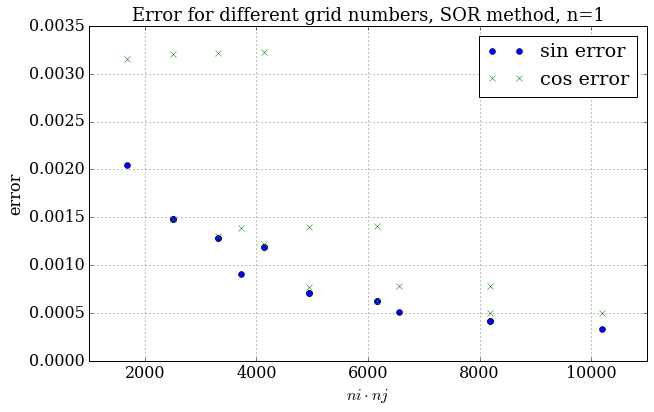

In [5]:
error_SORsin_grid=[]
error_SORcos_grid=[]
ninj=[]
for ni in range(41,102,20):
    for nj in range(41,102,20):
        error_SORsin_grid.append(SORsin(ni,nj,1,1e-9,1.9)[4])
        error_SORcos_grid.append(SORcos(ni,nj,1,1e-9,1.9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$ni \cdot nj$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_SORsin_grid,'o')
pyplot.plot(ninj,error_SORcos_grid,'x')
pyplot.title('Error for different grid numbers, SOR method, n=1',fontsize=18)
pyplot.legend(['sin error','cos error']);